## 4. Spatial model using $NO_2$ data

On Copernicus Hub, ESA makes data from the Sentinel 5P mission available, which, among many other things, measures $NO_2$ pollution in the atmosphere. If this data correlates with traffic, it can be used to account for the effects of the curfew - the less travel, the more people adhere to the curfew. This data is especially useful for us because traffic may have dropped at different rates in different places. The high resolution of the Sentinel 5P data allows us to observe regional differences in traffic reduction.

Our data has been obtained from the [Copernicus Atmosphere Monitoring Service](https://apps.ecmwf.int/datasets/data/cams-nrealtime/levtype=sfc/
).

Note, however, that not  all $NO_2$ is produced by cars. Other sources include refineriesor coal plants. The percentage of $NO_2$ produced by vehicles varies widely between locations, but seems to be somewhere between 40-80%. The fraction of $NO_2$ that actually stems from trafic is one of the parameters to be calibrated for this model. But in reality that fraction will likely vary very much from place to place, so using one global variable can only ever be an approximation of the real situation.

Once we know the fraction $f_{NO_2}$ by which $NO_2$ has dropped due to reduction in traffic, we can use this to update our connectivity (instead of using the global variable $u$ like in section 3):

$$ C_{x, y, 1} = f_{NO_2} \cdot C_{x, y, 0} $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc, animation
from IPython.display import HTML
import pandas as pd
import geopandas as gpd

from models import spatialModelNO2, minimize, getMsseRelative
from plotting import plotSim, plotSimCuml, plotSimMulti, scatterHistory, video, getIndex


dataDir = './data/centered'
data = gpd.read_file(f"{dataDir}/landkreise_no2_30d.json")
dateColNames = data.columns[6:-5]

incubationTime = 7
t_infectious = 14
t_curfew = getIndex('22.03.2020', dateColNames)
t_curfew_effect = t_curfew + incubationTime

n_obs = data[dateColNames].values
nrPlaces, nrTimesteps = n_obs.shape
n0 = n_obs[:, 0]
population = data['population'].values
Ks = population
geometries = data.geometry

msseRelPop = getMsseRelative(population / 1000)

In [2]:
alpha0_est = 0.03
alpha0_bounds = (0.001, 0.5)
alpha1f_est = 0.5
alpha1f_bounds = (0.1, 1)
sp0_est = 0.5
sp0_bounds = (0.01, 1)
sp1_est = 0.4
sp1_bounds = (0.01, 1)
fTrafficMidn_est = 0.2
fTrafficMidn_bounds = (0.01, 0.95)

no2_before_day = data['obs_no2_mean_before']
no2_after_day = data['obs_no2_mean_after']
no2_before_night = data['obs_no2_midnight_mean_before']
no2_after_night = data['obs_no2_midnight_mean_after']

results_no2, _ = minimize(
        n_obs, spatialModelNO2, 
        [alpha0_est, alpha1f_est, sp0_est, sp1_est, fTrafficMidn_est],
        [alpha0_bounds, alpha1f_bounds, sp0_bounds, sp1_bounds, fTrafficMidn_bounds],
        [nrPlaces, nrTimesteps, Ks, n0, geometries, t_curfew_effect, t_curfew, t_infectious, no2_before_day, no2_after_day, no2_before_night, no2_after_night], 
        msseRelPop)
results_no2

      fun: nan
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([nan, nan, nan, nan, nan])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 126
      nit: 0
   status: 2
  success: False
        x: array([0.03, 0.5 , 0.5 , 0.4 , 0.2 ])

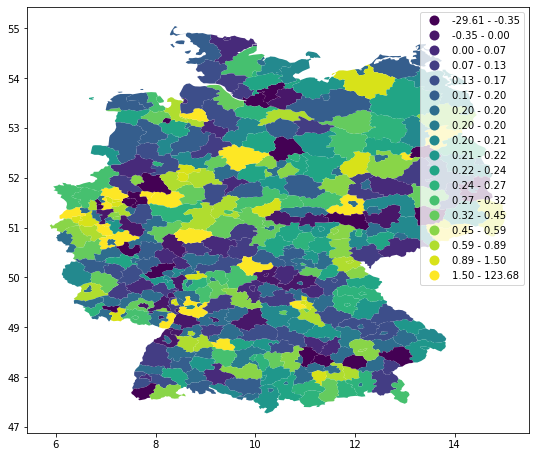

In [3]:
nontraffic = no2_after_night * 0.7
traffic_before = no2_before_day - nontraffic
traffic_after = no2_after_day - nontraffic
data['frac'] = traffic_after / traffic_before
data.plot(column='frac', scheme='quantiles', k=20, legend=True, figsize=(9, 9))

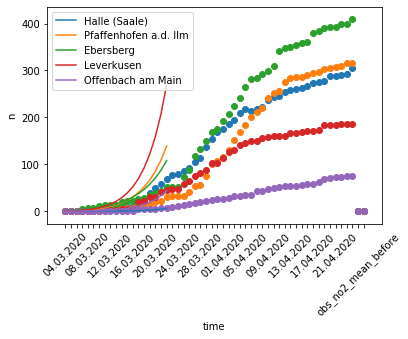

In [4]:
n_sim_no2 = spatialModelNO2(*(results_no2.x),
                        nrPlaces, nrTimesteps, Ks, n0, geometries, t_curfew_effect, t_curfew, t_infectious, no2_before_day, no2_after_day, 
                        no2_before_night, no2_after_night)

n_obs_plt = []
n_sim_plt = []
names = []
for i in range(0, 50, 10):
    n_obs_plt.append(n_obs[i])
    n_sim_plt.append(n_sim_no2[i])
    names.append(data.loc[i, 'GEN'])
plotSimMulti(dateColNames, n_obs_plt, n_sim_plt, names)

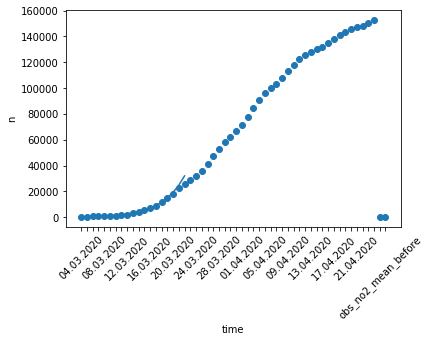

In [5]:
plotSimCuml(dateColNames, n_obs, n_sim_no2)